# Model developing

In [230]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [231]:
# Load data
data = pd.read_csv('../data/booli_apartments.csv')

# Drop address and city as it is individual for each apartment and all apartments are in same area
data = data.drop(['address', 'city'], axis=1)

# Convert 'date' to datetime and extract year and month
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data = data.drop('date', axis=1)

# Convert 'top_floor' to int64
data['top_floor'] = data['top_floor'].astype('int64')

# Drop multi-collinear features
data = data.drop(['price_change', 'price_per_m2', 'ask_price', 'total_floors'], axis=1)

data.head()

,rooms,area,floor,top_floor,elevator,balcony,sell_price,interest_rate,year,month
0,2.0,54.0,6.0,0,1,0,3000000,3.75,2024,5
1,2.0,55.5,2.0,0,1,0,3250000,3.75,2024,5
2,2.0,42.0,1.0,0,0,0,3095000,4.00,2024,1
3,1.5,39.0,4.0,0,1,0,2450000,4.00,2024,5
4,2.0,55.0,8.0,1,1,0,3866000,3.75,2024,5


In [232]:
data.dtypes

rooms            float64
area             float64
floor            float64
top_floor          int64
elevator           int64
balcony            int64
sell_price         int64
interest_rate    float64
year               int64
month              int64
dtype: object

In [233]:
Y = data['sell_price']
X = data.drop(['sell_price'], axis=1)

# Transform categorical variables to one-hot encoding
X = pd.get_dummies(X)

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [242]:
# Assuming you have a validation set (X_val, Y_val)
model = xgb.XGBRegressor(objective ='reg:squarederror',
                         booster='dart',
                         n_estimators=2200,
                         max_depth=4,
                         learning_rate=0.01,
                         tree_method='hist',
                         device='cuda')
model.fit(X_train, Y_train,
          eval_set=[(X_train, Y_train), (X_test, Y_test)],
          eval_metric='rmse',
          verbose=100)

[0]	validation_0-rmse:837078.79364	validation_1-rmse:822492.65583


/opt/anaconda3/envs/islp/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:551153.87729	validation_1-rmse:548034.54610
[200]	validation_0-rmse:475811.50030	validation_1-rmse:480310.46766
[300]	validation_0-rmse:447368.26931	validation_1-rmse:456955.18215
[400]	validation_0-rmse:431384.64772	validation_1-rmse:445244.96837
[500]	validation_0-rmse:421766.48370	validation_1-rmse:439741.44635
[600]	validation_0-rmse:414884.90306	validation_1-rmse:436438.56937
[700]	validation_0-rmse:408732.60925	validation_1-rmse:433242.67708
[800]	validation_0-rmse:403739.81084	validation_1-rmse:431798.82539
[900]	validation_0-rmse:398617.35709	validation_1-rmse:429789.35927
[1000]	validation_0-rmse:393682.75825	validation_1-rmse:427477.13291
[1100]	validation_0-rmse:388754.53339	validation_1-rmse:427194.20457
[1200]	validation_0-rmse:384937.99471	validation_1-rmse:426455.81776
[1300]	validation_0-rmse:380294.91287	validation_1-rmse:425886.21236
[1400]	validation_0-rmse:376216.91620	validation_1-rmse:425678.93456
[1500]	validation_0-rmse:372881.78934	valid

XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [243]:
# Predict the test set
Y_pred = model.predict(X_test)

In [244]:
# Calculate the mean squared error to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 177705205712.05594


In [237]:
# Feature importance
feature_importance = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

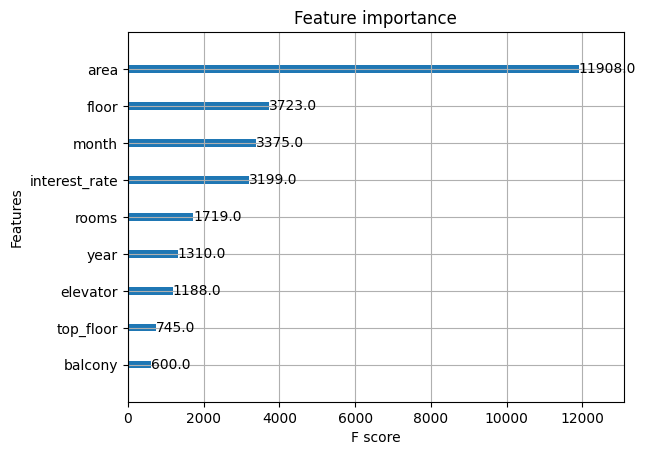

In [238]:
xgb.plot_importance(model)
plt.show()

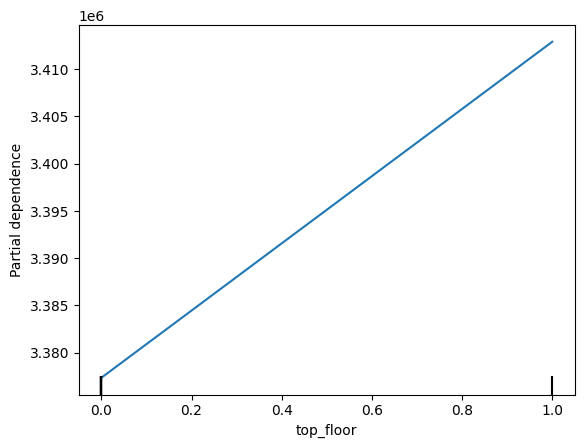

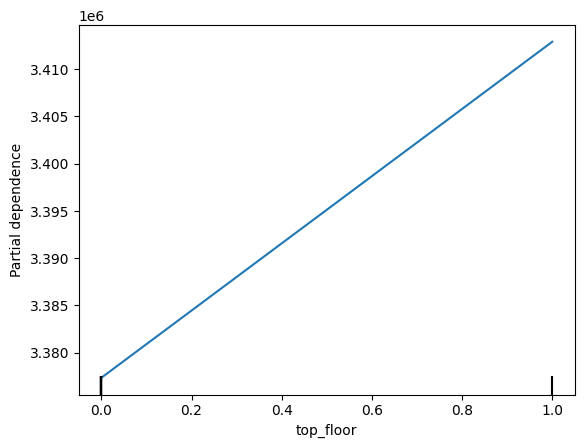

In [17]:
# Partial Dependence Plot för 'top_floor'
from sklearn.inspection import PartialDependenceDisplay
features = ['top_floor']
display = PartialDependenceDisplay.from_estimator(model, X_train, features=features)
display.plot()